<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Regression" data-toc-modified-id="Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Regression</a></span></li></ul></div>

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import gym
sns.set()

## Regression

In [398]:
# https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE
pd.set_option('display.max_columns', 500)
df = pd.read_excel('/content/data_reg.xlsx', index_col=0, skiprows=[0])
df.head()

,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
date,,,,,,,,,
2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [ ]:
scaler = preprocessing.MinMaxScaler()
X = df.drop(['ISE', 'ISE.1'], axis=1).values
X = scaler.fit_transform(X)
y = df['ISE.1']
y = scaler.fit_transform(y.values.reshape(-1, 1))

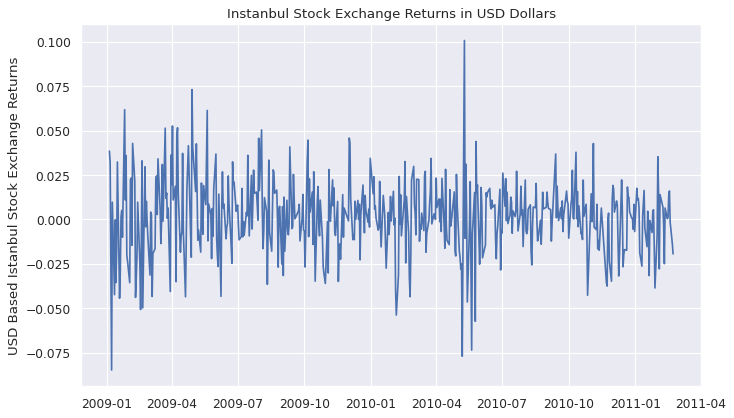

In [400]:
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Instanbul Stock Exchange Returns in USD Dollars")
plt.ylabel('USD Based Istanbul Stock Exchange Returns')
plt.plot(df['ISE.1']);

In [ ]:
def design_matrix(X, N, J):
  # J basis functions obtained by k-means clustering
  # sigma set to standard deviation of entire data
  kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
  # Construct design matrix
  U = np.zeros((N, J))
  for i in range(N):
      for j in range(J):
          U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j])
  return U

def values_scatter(name, yTarget, yEst):
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(yTarget, yEst)
    plt.title(name + " (Values Prediction)", fontsize=20)
    plt.xlabel("True Values", fontsize=18)
    plt.ylabel("Predicted Values", fontsize=18)
    #plt.savefig(name + " Values Prediction.svg", format='svg', dpi=1200)
    
def weights_scatter(name, wTrue, wEst):
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(wTrue, wEst)
    plt.title(name + " (Weights Prediction)", fontsize=20)
    plt.xlabel("True Weights", fontsize=18)
    plt.ylabel("Predicted Weights", fontsize=18)
    #plt.savefig(name+ " Weights Prediction.svg", format='svg', dpi=1200)

def compare_series(yTarget, yEst):
    plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.title("Estimated vs Actual Time Series Comparison", fontsize=20)
    plt.plot(yEst, label='Estimated Values')
    plt.plot(yTarget, label='Actual Values')
    plt.xlabel("X", fontsize=18)
    plt.ylabel("Y", fontsize=18)
    plt.legend(fontsize=16)
    plt.savefig('series.svg', format='svg', dpi=1200)
    plt.legend()

def plotting(Eplot, title, plot=True):
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(Eplot)
    plt.title(title, fontsize=20)
    plt.xlabel("Iteration Number", fontsize=18)
    plt.ylabel("Residual Error", fontsize=18)
    print("Training Error: ", Eplot[len(Eplot)-1][0])
    plt.savefig(title + '.svg', format='svg', dpi=1200)
    plt.show()

def sgd(X, yTarget, MaxIter, lRate, alpha=0, plot=True):
    Eplot = np.zeros((MaxIter, 1))
    wIter = np.random.randn(X.shape[1], 1)
    for itern in range(MaxIter):
        rand_sample = random.randint(0, X.shape[0]-1)
        x_rand_sample = np.reshape(X[rand_sample, :], (X[rand_sample, :].shape[0], 1)) 
        y_rand_sample = yTarget[rand_sample,:]
        yPred = x_rand_sample.T @ wIter
        # Stochastic Gradient Descent with L1 regularization
        wIter = wIter - lRate  * x_rand_sample * (yPred - y_rand_sample) + alpha * wIter
        Eplot[itern] = np.linalg.norm(X @ wIter - yTarget)
    
    if plot==True:
      plotting(Eplot,"Linear Regression using Stochastic Gradient Descent", plot)
    
    return wIter, Eplot[len(Eplot)-1][0]

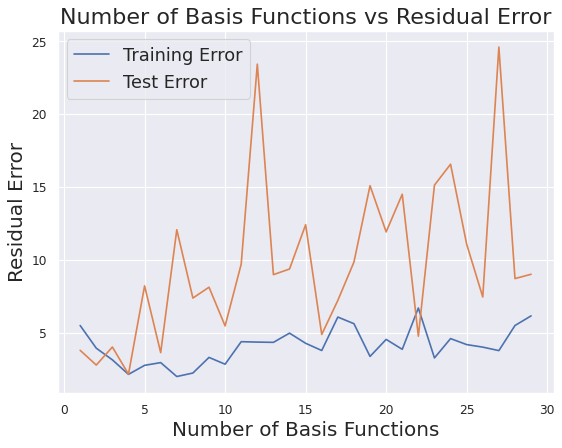

In [414]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

j_list = range(1, 30)
tr_error, test_error = [], []
for J in j_list:
  U = design_matrix(X_train, len(X_train), J)
  wEst, Err = sgd(U, y_train, len(X_train), 0.04, alpha=0, plot=False)
  tr_error.append(Err)
  U_test = design_matrix(X_test, len(X_test), J)
  yEst = U_test @ wEst
  test_error.append(np.linalg.norm(yEst - y_test))

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(j_list, tr_error, label='Training Error')
plt.plot(j_list, test_error, label='Test Error')
plt.title("Number of Basis Functions vs Residual Error", fontsize=20)
plt.xlabel("Number of Basis Functions", fontsize=18)
plt.ylabel("Residual Error", fontsize=18)
plt.legend(fontsize=16)
plt.savefig('best_j.svg', format='svg', dpi=1200)
plt.show()

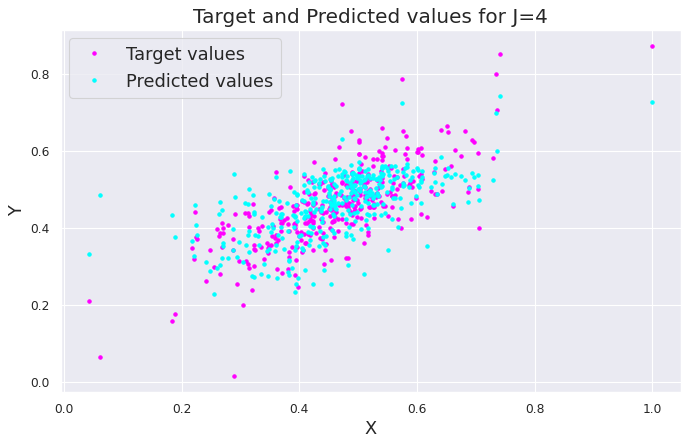

Target Training Error:  1.4990112411195673
Training Predicted RBF Moore-Penrose inverse Error:  1.730127738476373
Target Test Error:  0.9635708744394917
Test Predicted RBF Moore-Penrose inverse Error:  4.638855989274782


In [415]:
N = X_train.shape[0]
J = 4

# Solve linear regression, plot target and prediction
w = (np.linalg.inv(X_train.T @ X_train)) @ X_train.T @ y_train
yh_lin = X_train @ w
y_t = X_test @ w
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Target and Predicted values for J="+str(J), fontsize=18)
plt.plot(y_train, yh_lin, '.', Color='magenta', label='Target values')

# Solve RBF model, predict and plot using Moore-Penrose inverse
U = design_matrix(X_train, N, J)
w = np.dot((np.linalg.inv(np.dot(U.T, U))), U.T) @ y_train
yh_rbf = np.dot(U, w)
plt.plot(y_train, yh_rbf, '.', Color='cyan', label='Predicted values')
plt.xlabel("X", fontsize=16)
plt.ylabel("Y", fontsize=16)
plt.legend(fontsize=16)
plt.show()
print("Target Training Error: ", np.linalg.norm(y_train-yh_lin))
print("Training Predicted RBF Moore-Penrose inverse Error: ", np.linalg.norm(y_train-yh_rbf))

U_test = design_matrix(X_test, len(X_test), J)
y_rbf_t = np.dot(U_test, w)
print("Target Test Error: ", np.linalg.norm(y_test-y_t))
print("Test Predicted RBF Moore-Penrose inverse Error: ", np.linalg.norm(y_test-y_rbf_t))

Training Error:  2.0740193884202545


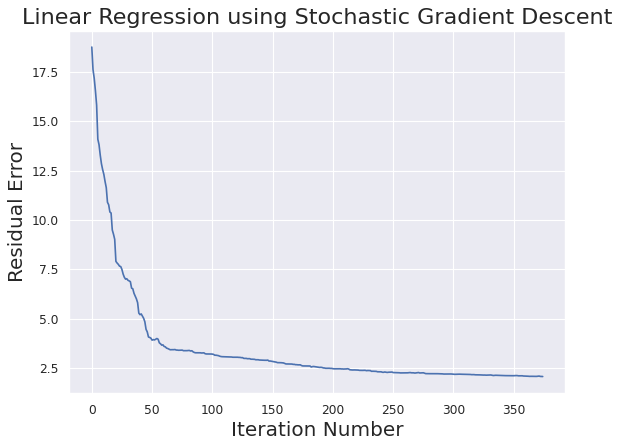

Residual Error:  3.128


In [416]:
wEst, Ep = sgd(U, y_train, N, 0.04, alpha=0, plot=True)
yEst = U_test @ wEst
# Test set residual error
print("Residual Error: ", round(np.linalg.norm(yEst - y_test), 3))
#values_scatter('SGD Linear Regression', y_test, yEst)
#weights_scatter('SGD Linear Regression', w, wEst)

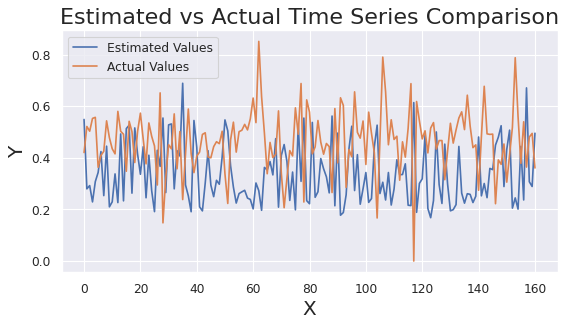

In [419]:
compare_series(y_test, yEst)

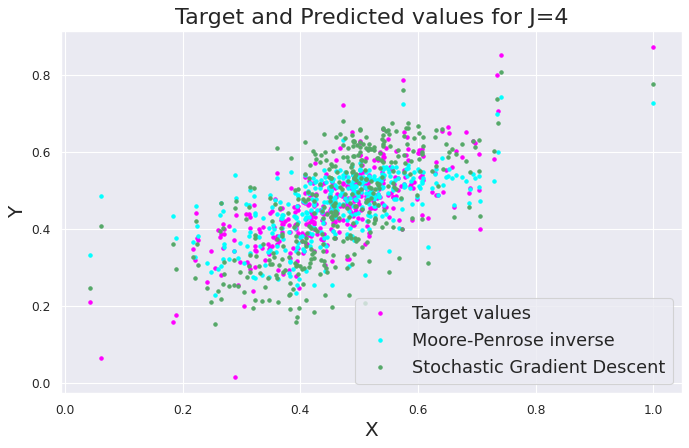

In [420]:
y_sgd = U @ wEst

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Target and Predicted values for J="+str(J), fontsize=20)
plt.plot(y_train, yh_lin, '.', Color='magenta', label='Target values')
plt.plot(y_train, yh_rbf, '.', Color='cyan', label='Moore-Penrose inverse')
plt.plot(y_train, y_sgd, '.', label='Stochastic Gradient Descent')
plt.xlabel("X", fontsize=18)
plt.ylabel("Y", fontsize=18)
plt.legend(fontsize=16)
plt.savefig('scatter.svg', format='svg', dpi=1200)
plt.show()

Training Error:  1.863888532265377


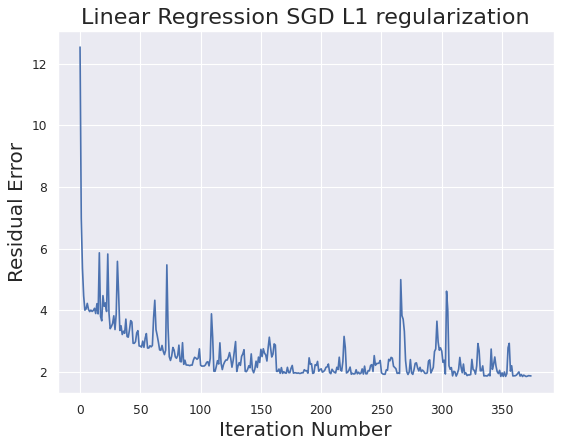

Residual Error:  2.947


In [547]:
wEst, Ep = sgd(U, y_train, N, 0.45, alpha=0.00002, plot=True)
yEst = U_test @ wEst
# Test set residual error
print("Residual Error: ", round(np.linalg.norm(yEst - y_test), 3))